In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import time
import librosa
import torch.cuda

## Ερώτημα 1: Feedforward Neural Network
### Βήμα 1: Φόρτωση δεδομένων (mfccs)

In [2]:
# Κάποια ερωτήματα χρειάστηκε να τα τρέξω στο colab. Για να τρέξει στο colab χρειάζεται αλλαγή των paths στην load_data function
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_data(dir_name):
    X_train = np.load(r'//content//drive//MyDrive//mathimata_sxolhs//EARINO_EKSAMHNO//Mhxanikh Mathish//Ergasia 3//data//music_genre_data_di//train//'+dir_name+'//X.npy')
    y_train = np.load(r'//content//drive//MyDrive//mathimata_sxolhs//EARINO_EKSAMHNO//Mhxanikh Mathish//Ergasia 3//data//music_genre_data_di//train//'+dir_name+'//labels.npy')

    X_val = np.load(r'//content//drive//MyDrive//mathimata_sxolhs//EARINO_EKSAMHNO//Mhxanikh Mathish//Ergasia 3//data//music_genre_data_di//val//'+dir_name+'//X.npy')
    y_val = np.load(r'//content//drive//MyDrive//mathimata_sxolhs//EARINO_EKSAMHNO//Mhxanikh Mathish//Ergasia 3//data//music_genre_data_di//val//'+dir_name+'//labels.npy')

    X_test = np.load(r'//content//drive//MyDrive//mathimata_sxolhs//EARINO_EKSAMHNO//Mhxanikh Mathish//Ergasia 3//data//music_genre_data_di//test//'+dir_name+'//X.npy')
    y_test = np.load(r'//content//drive//MyDrive//mathimata_sxolhs//EARINO_EKSAMHNO//Mhxanikh Mathish//Ergasia 3//data//music_genre_data_di//test//'+dir_name+'//labels.npy')

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data('mfccs')

### Barplot με το distribution των labels

Shape of X_train: (3200, 26)
Shape of y_train: (3200,)
Shape of X_val: (800, 26)
Shape of y_val: (800,)
Shape of X_test: (1376, 26)
Shape of y_test: (1376,)
Data types of X_train: float64
Data types of y_train: <U19


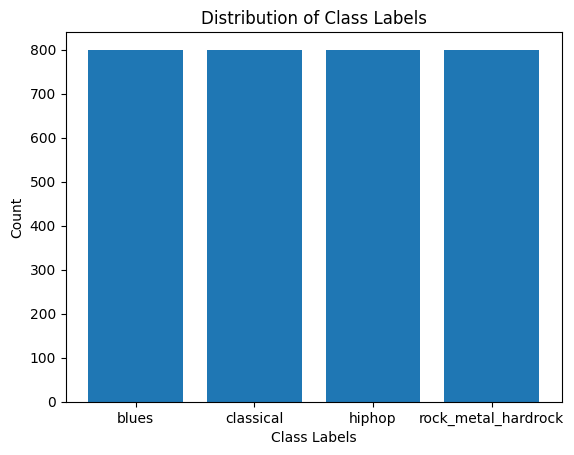

In [ ]:
# Step 1: Check dimensions and data types
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

print("Data types of X_train:", X_train.dtype)
print("Data types of y_train:", y_train.dtype)


# Examine target variable distribution
unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.bar(unique_classes, class_counts)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.show()




### Μετατροπή των categorical data σε numerical με την παρακάτω συνάρτηση

In [4]:
def categorical_to_numerical(y_train, y_val, y_test):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.fit_transform(y_val)
    y_test = le.fit_transform(y_test)
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    return y_train, y_val, y_test, mapping

y_train, y_val, y_test, mapping = categorical_to_numerical(y_train, y_val, y_test)

### Δημιουργία train, validation, test dataloaders

In [ ]:
#https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895
class CustomDatasetMFCCS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y


# Create custom datasets for train, validation, and test
train_dataset = CustomDatasetMFCCS(X_train, y_train)
val_dataset = CustomDatasetMFCCS(X_val, y_val)
test_dataset = CustomDatasetMFCCS(X_test, y_test)

# Create dataloaders for train, validation, and test
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
class fullyConnectedNN(nn.Module):
    def __init__(self):
        super(fullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

In [5]:
def train_one_epoch(optimizer, dataloader, loss_fn, model, device):
    size = len(dataloader.dataset)
    losses_ls = [] # Here we will keep all the loss values
    for batch, (X, y) in enumerate(dataloader):
        X = X.float() # https://discuss.pytorch.org/t/runtimeerror-mat1-and-mat2-must-have-the-same-dtype/166759/5
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        losses_ls.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 64 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return sum(losses_ls)/len(losses_ls), model


def test(dataloader, neural, loss_fn, device):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()

            X = X.to(device)
            y = y.to(device)

            pred = neural(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def train(epochs, optimizer, dataloader, loss_fn, neural, device):
    losses_ls = []
    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        loss, _ = train_one_epoch(optimizer, dataloader, loss_fn, neural, device)
        losses_ls.append(loss)
        test(dataloader, neural, loss_fn, device)
    return neural, losses_ls



### Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

In [6]:
def evaluate(dataloader, model, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    losses_ls = []


    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)
            losses_ls.append(loss.item())

            predictions.append(pred.argmax(1).cpu().numpy())
            targets.append(y.cpu().numpy())

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    mean_losses = np.mean(losses_ls)

    f1_macro = f1_score(targets, predictions, average='macro')
    accuracy = accuracy_score(targets, predictions)
    confusion_mat = confusion_matrix(targets, predictions)

    return mean_losses, f1_macro, accuracy, confusion_mat


### Βήμα 5: Εκπαίδευση δικτύου

In [ ]:
# Hyperparameters
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader
model = fullyConnectedNN()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
device = 'cpu'
start = time.time()
# Network training
model, _ = train(epochs, optimizer, dataloader, loss_fn, model, device)
end = time.time()
print(f"Time without GPU: {end - start}")
losses, f1_macro, accuracy, confusion_mat = evaluate(dataloader, model, loss_fn, device)
print(f'loss: {losses}\nf1_macro: {f1_macro}\naccuracy:{accuracy}\n')

Epoch 1
-------------------------------
loss: 1.401104  [    0/ 3200]
loss: 1.372464  [ 1024/ 3200]
loss: 1.377115  [ 2048/ 3200]
loss: 1.380419  [ 3072/ 3200]
Test Error: 
 Accuracy: 35.9%, Avg loss: 0.086040 

Epoch 2
-------------------------------
loss: 1.379496  [    0/ 3200]
loss: 1.384148  [ 1024/ 3200]
loss: 1.326983  [ 2048/ 3200]
loss: 1.371497  [ 3072/ 3200]
Test Error: 
 Accuracy: 49.3%, Avg loss: 0.085607 

Epoch 3
-------------------------------
loss: 1.376555  [    0/ 3200]
loss: 1.358723  [ 1024/ 3200]
loss: 1.389326  [ 2048/ 3200]
loss: 1.370595  [ 3072/ 3200]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.085369 

Epoch 4
-------------------------------
loss: 1.365686  [    0/ 3200]
loss: 1.375540  [ 1024/ 3200]
loss: 1.371102  [ 2048/ 3200]
loss: 1.364590  [ 3072/ 3200]
Test Error: 
 Accuracy: 28.6%, Avg loss: 0.084919 

Epoch 5
-------------------------------
loss: 1.351389  [    0/ 3200]
loss: 1.381889  [ 1024/ 3200]
loss: 1.340916  [ 2048/ 3200]
loss: 1.356696  [ 3072

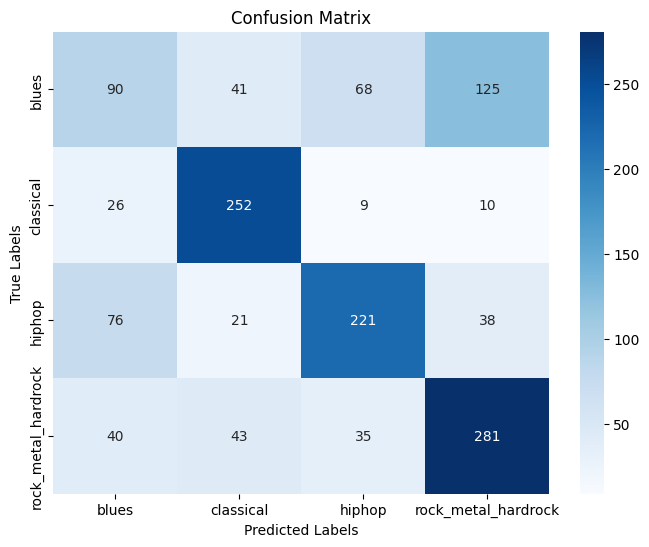

In [ ]:
def plot_confusion_matrix(confusion_mat, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

labels = list(mapping.keys())
confusion_mat = evaluate(test_dataloader, model, loss_fn, device)[-1]  # Get the confusion matrix from evaluate()
plot_confusion_matrix(confusion_mat, labels)

### Βήμα 6: Εκπαίδευση δικτύου με GPU
(Σημείωση): Αυτό το βήμα εκτελέστηκε στο colab, επίσης άλλαξα τα paths για τα data στην load_data(dir_name) function

In [ ]:
#%%capture
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader
model = fullyConnectedNN()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
device = 'cpu' # we simply change the runtime option to GPU so that variable's value don't matter so we live it as is.
start = time.time()
# Network training
model, _ = train(epochs, optimizer, dataloader, loss_fn, model, device)
end = time.time()
print(f"Time with GPU: {end - start}")
losses, f1_macro, accuracy, confusion_mat = evaluate(dataloader, model, loss_fn, device)
print(f'loss: {losses}\nf1_macro: {f1_macro}\naccuracy:{accuracy}\n')

Epoch 1
-------------------------------
loss: 1.346674  [    0/ 3200]
loss: 1.398057  [ 1024/ 3200]
loss: 1.387296  [ 2048/ 3200]
loss: 1.377294  [ 3072/ 3200]
Test Error: 
 Accuracy: 25.8%, Avg loss: 0.086210 

Epoch 2
-------------------------------
loss: 1.382395  [    0/ 3200]
loss: 1.363612  [ 1024/ 3200]
loss: 1.353172  [ 2048/ 3200]
loss: 1.371705  [ 3072/ 3200]
Test Error: 
 Accuracy: 27.0%, Avg loss: 0.085871 

Epoch 3
-------------------------------
loss: 1.345586  [    0/ 3200]
loss: 1.376249  [ 1024/ 3200]
loss: 1.331795  [ 2048/ 3200]
loss: 1.371582  [ 3072/ 3200]
Test Error: 
 Accuracy: 28.3%, Avg loss: 0.085510 

Epoch 4
-------------------------------
loss: 1.387015  [    0/ 3200]
loss: 1.356895  [ 1024/ 3200]
loss: 1.423984  [ 2048/ 3200]
loss: 1.371453  [ 3072/ 3200]
Test Error: 
 Accuracy: 36.9%, Avg loss: 0.085042 

Epoch 5
-------------------------------
loss: 1.363659  [    0/ 3200]
loss: 1.371581  [ 1024/ 3200]
loss: 1.343957  [ 2048/ 3200]
loss: 1.314462  [ 3072

### Βήμα 7: Επιλογή μοντέλου

In [7]:
#%%capture
def choose_best_model(epochs, learning_rate, train_dataloader, val_dataloader, model, optimizer):
  loss_fn = nn.CrossEntropyLoss()

  f1_best=0
  epoch_best=0
  train_losses_ls = []
  val_losses_ls = []
  accuracy_ls = []

  # For each epoch
  for epoch in range(epochs):
      print(f"Epoch {epoch+1}")

      # Training
      train_loss, _ = train_one_epoch(optimizer, train_dataloader, loss_fn,  model, device)
      train_losses_ls.append(train_loss)

      # Evaluate on the validation set
      val_loss, f1_val, accuracy, _ = evaluate(val_dataloader, model, loss_fn, device)
      val_losses_ls.append(val_loss)
      accuracy_ls.append(accuracy)
      print(f'f1_val = {f1_val}')
      # If it performed better
      if (f1_best < f1_val):
          best_epoch = epoch
          f1_best = f1_val
          best_model = model.state_dict()

  # Load the best model's state_dict to the model
  model.load_state_dict(best_model)
  mean_accuracy = np.mean(accuracy_ls)

  return model, best_epoch, f1_best, train_losses_ls, val_losses_ls, mean_accuracy



In [ ]:
model = fullyConnectedNN()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model, best_epoch, f1_best, _, _, _ = choose_best_model(30, 2e-3, train_dataloader, val_dataloader, model, optimizer)
print(f'Best epoch: {best_epoch} Best f1: {f1_best}')

Epoch 1
loss: 1.481725  [    0/ 3200]
loss: 1.401918  [ 1024/ 3200]
loss: 1.385525  [ 2048/ 3200]
loss: 1.394118  [ 3072/ 3200]
f1_val = 0.1
Epoch 2
loss: 1.398566  [    0/ 3200]
loss: 1.388376  [ 1024/ 3200]
loss: 1.394176  [ 2048/ 3200]
loss: 1.347168  [ 3072/ 3200]
f1_val = 0.11355077548587054
Epoch 3
loss: 1.387901  [    0/ 3200]
loss: 1.374819  [ 1024/ 3200]
loss: 1.387261  [ 2048/ 3200]
loss: 1.370421  [ 3072/ 3200]
f1_val = 0.1
Epoch 4
loss: 1.387271  [    0/ 3200]
loss: 1.379915  [ 1024/ 3200]
loss: 1.345501  [ 2048/ 3200]
loss: 1.399784  [ 3072/ 3200]
f1_val = 0.11763337468982632
Epoch 5
loss: 1.400344  [    0/ 3200]
loss: 1.375625  [ 1024/ 3200]
loss: 1.367135  [ 2048/ 3200]
loss: 1.344450  [ 3072/ 3200]
f1_val = 0.237956272725854
Epoch 6
loss: 1.341518  [    0/ 3200]
loss: 1.371064  [ 1024/ 3200]
loss: 1.354811  [ 2048/ 3200]
loss: 1.369417  [ 3072/ 3200]
f1_val = 0.10526371242193158
Epoch 7
loss: 1.369892  [    0/ 3200]
loss: 1.361213  [ 1024/ 3200]
loss: 1.356485  [ 2048/ 

## Ερώτημα 2: Convolutional Neural Network
### Βήμα 1: Φόρτωση δεδομένων

In [8]:
X_train_mel, y_train_mel, X_val_mel, y_val_mel, X_test_mel, y_test_mel = load_data('melgrams')

### Εξετάζουμε τα δεδομένα μας

Shape of X_train: (3200, 26)
Shape of y_train: (3200,)
Shape of X_val: (800, 26)
Shape of y_val: (800,)
Shape of X_test: (1376, 26)
Shape of y_test: (1376,)
Data types of X_train: float64
Data types of y_train: int64


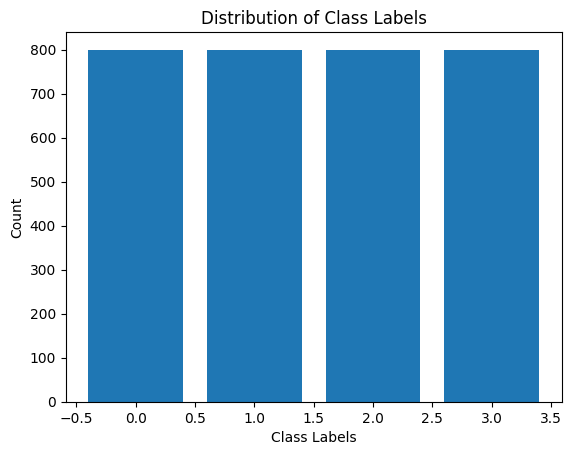

In [ ]:

# Step 1: Check dimensions and data types
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

print("Data types of X_train:", X_train.dtype)
print("Data types of y_train:", y_train.dtype)


# Examine target variable distribution
unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.bar(unique_classes, class_counts)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.show()

### Οπτικοποίηση τυχαίου melgram από κάθε κλάση

In [9]:
def visualize_random_melgrams(X, y):
    unique_classes = np.unique(y)
    fig, axs = plt.subplots(1, len(unique_classes), figsize=(10, 20))

    for i, class_label in enumerate(unique_classes):
        class_idx = np.where(y == class_label)[0]
        random_idx = np.random.choice(class_idx)

        # Get the melgram and its corresponding class label
        melgram = X[random_idx]
        label = str(class_label)

        # Plot the melgram
        axs[i].imshow(melgram, cmap='gray')
        axs[i].set_title(label)
        axs[i].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()




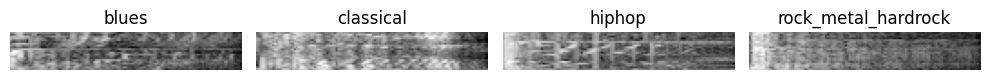

In [10]:
# Call the function to visualize random melgrams from each class
visualize_random_melgrams(X_train_mel, y_train_mel)
y_train_mel, y_val_mel, y_test_mel, mapping_mel = categorical_to_numerical(y_train_mel, y_val_mel, y_test_mel)

In [11]:
class CustomDatasetMEL(Dataset):
    def __init__(self, X, y):
        X = X[:, np.newaxis, :, :] # (batch_size, height, width) --> (batch_size, 1, height, width). The new axis represents the channel dimension
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [12]:
# Create custom datasets for train, validation, and test
train_dataset_mel = CustomDatasetMEL(X_train_mel, y_train_mel)
val_dataset_mel = CustomDatasetMEL(X_val_mel, y_val_mel)
test_dataset_mel = CustomDatasetMEL(X_test_mel, y_test_mel)

# Create dataloaders for train, validation, and test
train_dataloader_mel = DataLoader(train_dataset_mel, batch_size=16, shuffle=True)
val_dataloader_mel = DataLoader(val_dataset_mel, batch_size=16, shuffle=True)
test_dataloader_mel = DataLoader(test_dataset_mel, batch_size=16, shuffle=False)

In [ ]:
print(train_dataset_mel.X.size())

# Άρα το Height και το Width μετά από 4 layers είναι 21 και 128 αντίστοιχα
height_out = list(train_dataset_mel.X.size())[2]
width_out = list(train_dataset_mel.X.size())[3]

torch.Size([3200, 1, 21, 128])


### Βήμα 2: Ορισμός Νευρωνικού Δικτύου

<ul>
<li>$Stride $= 1</li>
<li>$Padding $= 0</li>
<li>$Kernels $= 5</li>
<br>
<li>$H_{out} = \frac{H_{in}-K+2P}{S} +$1</li>
<br>
<li>$W_{out} = \frac{W_{in}-K+2P}{S} +$1</li>
</ul>
Άρα μετά από 4 layers το height θα είναι

\begin{align*}
\text{height_out} &= (((21-4)-4)-4)-4= 5
\end{align*}
<br>
\begin{align*}
\text{width_out} &= (((128-4)-4)-4)-4= 112
\end{align*}

Άρα το **input dimension** θα είναι
\begin{align*}
\text{dim} &= 5 * 112 * 128 = 71680
\end{align*}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        # Fully connected layers
        self.fc1 = nn.Linear(71680, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x


### Βήμα 3: Εκπαίδευση δικτύου
Παρατηρούμε πως το accuracy δεν αυξάνετε, οπότε καλό θα ήταν να εφαρμόσουμε early stopping

In [ ]:
# Hyperparameters
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

start = time.time()
# Network training
model, _, _, _, _, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
end = time.time()
print(f"Time with GPU: {end - start}")


Epoch 1
loss: 1.435691  [    0/ 3200]
loss: 1.311067  [ 1024/ 3200]
loss: 1.152859  [ 2048/ 3200]
loss: 1.156172  [ 3072/ 3200]
f1_val = 0.5293868419666137
Epoch 2
loss: 1.162814  [    0/ 3200]
loss: 0.893196  [ 1024/ 3200]
loss: 1.162736  [ 2048/ 3200]
loss: 0.813444  [ 3072/ 3200]
f1_val = 0.6033840282161653
Epoch 3
loss: 1.117062  [    0/ 3200]
loss: 0.984634  [ 1024/ 3200]
loss: 1.222306  [ 2048/ 3200]
loss: 1.112342  [ 3072/ 3200]
f1_val = 0.4885913272610631
Epoch 4
loss: 0.769168  [    0/ 3200]
loss: 1.131029  [ 1024/ 3200]
loss: 0.862336  [ 2048/ 3200]
loss: 0.462845  [ 3072/ 3200]
f1_val = 0.5904105548931592
Epoch 5
loss: 0.593337  [    0/ 3200]
loss: 0.990106  [ 1024/ 3200]
loss: 0.668780  [ 2048/ 3200]
loss: 0.901811  [ 3072/ 3200]
f1_val = 0.587535900716996
Epoch 6
loss: 0.517354  [    0/ 3200]
loss: 0.881206  [ 1024/ 3200]
loss: 0.519057  [ 2048/ 3200]
loss: 0.499017  [ 3072/ 3200]
f1_val = 0.613382683575406
Epoch 7
loss: 0.904561  [    0/ 3200]
loss: 0.552238  [ 1024/ 3200

In [ ]:
losses, f1_macro, accuracy, confusion_mat = evaluate(dataloader, model, loss_fn, device)
print(f'loss: {losses}\nf1_macro: {f1_macro}\naccuracy:{accuracy}\n')

loss: 0.003993808590748813
f1_macro: 0.9996874998779297
accuracy:0.9996875



### Βήμα 4: Pooling and padding
Θα χρησιμοποιήσουμε τον τύπο που χρησιμοποιήσαμε και παραπάνω για να βρούμε την διάσταση της εισόδου του fully connected neural network.
<br>
\begin{align*}
H_{out} = \frac{H_{in}-K+2P}{S} +1  = \frac{H_{in}-5+4}{1} +1 = {H_{in}}
\end{align*}
<br>
Αντίστοιχα:
\begin{align*}
W_{out} = W_{in}
\end{align*}
Μετά από 4 layers έχουμε:
\begin{align*}
H_{out} = 1\\
W_{out} = 8
\end{align*}
Άρα έχουμε τελικό dimension:
\begin{align*}
1*8*128=1024
\end{align*}

Το <b>pooling</b> και το <b>padding</b> είναι χρήσιμα γιατι:
  <ol>
  <li><b>Padding</b>: Βοηθά στη διατήρηση των χωρικών διαστάσεων της εισόδου. Επιτρέπει στα συνελικτικά επίπεδα να ανιχνεύουν χαρακτηριστικά από την εισαγωγή με μεγαλύτερη αποτελεσματικότητα</li>
  <li><b>Pooling</b>: Πραγματοποιέι μείωση των χωρικών διαστάσεων των χαρακτηριστικών παράλληλα με τη διατήρηση των πιο σημαντικών χαρακτηριστικών.  Bοηθά στην επίτευξη ανεξαρτησίας από τις μετατοπίσεις επιλέγοντας τα ισχυρότερα χαρακτηριστικά σε κάθε περιοχή και απορρίπτοντας τα λιγότερο σημαντικά</li>
  </ol>
Για τους παραπάνω λόγους το συνελικτικό δίκτυο μας πετυχαίνει μεγαλύτερο <b>f1 score</b> και εκπαιδεύεται πολύ πιο γρήγορα.

In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)

        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)

        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)

        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):

        x = F.max_pool2d(self.conv1(x), kernel_size=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2)
        x = F.max_pool2d(self.conv3(x), kernel_size=2)
        x = F.max_pool2d(self.conv4(x), kernel_size=2)
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x


In [ ]:
#%%capture
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
model = CNN_2()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

start = time.time()
# Network training
model, _, _, _, _, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
end = time.time()
print(f"Time with GPU: {end - start}")


Epoch 1
loss: 1.370917  [    0/ 3200]
loss: 1.336733  [ 1024/ 3200]
loss: 1.267433  [ 2048/ 3200]
loss: 1.314382  [ 3072/ 3200]
f1_val = 0.3369849549288668
Epoch 2
loss: 1.110923  [    0/ 3200]
loss: 1.073822  [ 1024/ 3200]
loss: 1.479852  [ 2048/ 3200]
loss: 0.820240  [ 3072/ 3200]
f1_val = 0.3570350569510289
Epoch 3
loss: 1.340293  [    0/ 3200]
loss: 1.172466  [ 1024/ 3200]
loss: 1.080841  [ 2048/ 3200]
loss: 0.948621  [ 3072/ 3200]
f1_val = 0.5759033080429735
Epoch 4
loss: 0.873558  [    0/ 3200]
loss: 0.947013  [ 1024/ 3200]
loss: 0.822565  [ 2048/ 3200]
loss: 1.007166  [ 3072/ 3200]
f1_val = 0.530529486830251
Epoch 5
loss: 0.856729  [    0/ 3200]
loss: 0.713924  [ 1024/ 3200]
loss: 0.717225  [ 2048/ 3200]
loss: 0.825960  [ 3072/ 3200]
f1_val = 0.4598398336061175
Epoch 6
loss: 1.025359  [    0/ 3200]
loss: 0.732299  [ 1024/ 3200]
loss: 0.914571  [ 2048/ 3200]
loss: 0.831645  [ 3072/ 3200]
f1_val = 0.5973972716158974
Epoch 7
loss: 0.797622  [    0/ 3200]
loss: 0.940485  [ 1024/ 320

### Βήμα 5: Αλγόριθμοι βελτιστοποίησης

In [ ]:
#%%capture
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
loss_fn = nn.CrossEntropyLoss()
device = 'cpu'
model = CNN_2()
results = {}
optimizers_d = {
                'SGD': torch.optim.SGD(model.parameters(), lr = learning_rate),
                'Adadelta': torch.optim.Adadelta(model.parameters(), lr = learning_rate),
                'Adagrad': torch.optim.Adagrad(model.parameters(), lr = learning_rate),
                'Adam': torch.optim.Adam(model.parameters(), lr = learning_rate),
                'Adamax': torch.optim.Adamax(model.parameters(), lr = learning_rate)
              }

results = {key:{'F1':0, 'Accuracy':0} for key in optimizers_d.keys()}
for opt, obj in optimizers_d.items():
  model, _, _, _, _,_ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, obj)
  _, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)
  results[opt]['F1'] = f1_macro
  results[opt]['Accuracy'] = accuracy


Epoch 1
loss: 1.370994  [    0/ 3200]
loss: 1.360530  [ 1024/ 3200]
loss: 1.247940  [ 2048/ 3200]
loss: 1.209382  [ 3072/ 3200]
f1_val = 0.37484913642781037
Epoch 2
loss: 1.136083  [    0/ 3200]
loss: 1.362371  [ 1024/ 3200]
loss: 1.035677  [ 2048/ 3200]
loss: 1.132733  [ 3072/ 3200]
f1_val = 0.30957082886614806
Epoch 3
loss: 1.400851  [    0/ 3200]
loss: 0.993629  [ 1024/ 3200]
loss: 0.742914  [ 2048/ 3200]
loss: 1.075282  [ 3072/ 3200]
f1_val = 0.42213728735712314
Epoch 4
loss: 0.901310  [    0/ 3200]
loss: 0.950468  [ 1024/ 3200]
loss: 0.899912  [ 2048/ 3200]
loss: 0.813654  [ 3072/ 3200]
f1_val = 0.5879259131987339
Epoch 5
loss: 0.993520  [    0/ 3200]
loss: 0.756420  [ 1024/ 3200]
loss: 0.737535  [ 2048/ 3200]
loss: 0.750689  [ 3072/ 3200]
f1_val = 0.6086688763809674
Epoch 6
loss: 0.579220  [    0/ 3200]
loss: 0.813572  [ 1024/ 3200]
loss: 0.832033  [ 2048/ 3200]
loss: 0.686123  [ 3072/ 3200]
f1_val = 0.6671570276990431
Epoch 7
loss: 0.924459  [    0/ 3200]
loss: 0.738586  [ 1024/

In [ ]:
results_df = pd.DataFrame.from_dict(results)
results_df.T

,F1,Accuracy
SGD,0.662678,0.67500
Adadelta,0.748502,0.74875
Adagrad,0.745062,0.74625
Adam,0.581194,0.57625
Adamax,0.655573,0.65250


## Ερώτημα 3: Improving Performance
### Βήμα 1: Reproducibility

In [13]:
# https://darinabal.medium.com/deep-learning-reproducible-results-using-pytorch-42034da5ad7
def set_seed(SEED=55, disable_cudnn=False):
  torch.manual_seed(SEED)
  np.random.seed(SEED)
  rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(SEED)))
  np.random.seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  if not disable_cudnn:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  else:
    torch.backends.cudnn.enabled = False

set_seed()

### Βήμα 2: Activation functions

In [ ]:
class CNN_3(nn.Module):
    def __init__(self, activation_fn):
        super(CNN_3, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        # Activation function
        self.activation_fn = activation_fn

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.activation_fn(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.activation_fn(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.activation_fn(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with activation function
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = self.activation_fn(self.fc3(x))
        x = self.fc4(x)

        return x


In [ ]:
#%%capture
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
loss_fn = nn.CrossEntropyLoss()
device = 'cpu'

activation_fn_d = {'ELU': nn.ELU(), 'Hardshrink': nn.Hardshrink(), 'LeakyReLU': nn.LeakyReLU(), 'ReLU': nn.ReLU(), 'Mish': nn.Mish()}
results = {key:{'F1':0, 'Accuracy':0} for key in activation_fn_d.keys()}
set_seed()
for act_name, act_obj in activation_fn_d.items():
  model = CNN_3(act_obj)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  model, _, _, _, _, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  _, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)
  results[act_name]['F1'] = f1_macro
  results[act_name]['Accuracy'] = accuracy

Epoch 1
loss: 1.403692  [    0/ 3200]
loss: 1.397621  [ 1024/ 3200]
loss: 1.069362  [ 2048/ 3200]
loss: 0.697510  [ 3072/ 3200]
f1_val = 0.701919911234974
Epoch 2
loss: 0.816979  [    0/ 3200]
loss: 0.955167  [ 1024/ 3200]
loss: 0.915522  [ 2048/ 3200]
loss: 0.739162  [ 3072/ 3200]
f1_val = 0.7015892096865752
Epoch 3
loss: 0.462808  [    0/ 3200]
loss: 0.820589  [ 1024/ 3200]
loss: 0.605330  [ 2048/ 3200]
loss: 0.788653  [ 3072/ 3200]
f1_val = 0.7593408485610859
Epoch 4
loss: 0.295042  [    0/ 3200]
loss: 0.794830  [ 1024/ 3200]
loss: 0.299457  [ 2048/ 3200]
loss: 0.568632  [ 3072/ 3200]
f1_val = 0.658533945841197
Epoch 5
loss: 0.737508  [    0/ 3200]
loss: 0.343155  [ 1024/ 3200]
loss: 0.553605  [ 2048/ 3200]
loss: 0.266925  [ 3072/ 3200]
f1_val = 0.734019017713543
Epoch 6
loss: 0.563350  [    0/ 3200]
loss: 0.460882  [ 1024/ 3200]
loss: 0.445116  [ 2048/ 3200]
loss: 0.237504  [ 3072/ 3200]
f1_val = 0.7878145613262699
Epoch 7
loss: 0.505834  [    0/ 3200]
loss: 0.281077  [ 1024/ 3200]

### Παρατηρούμε πως το activation function **ELU** αποδίδει καλύτερα
Η συνάρτηση ενεργοποίησης ELU (Exponential Linear Unit) είναι γνωστή για τα καλά αποτελέσματα που παρέχει σε ορισμένες περιπτώσεις. Ορισμένοι λόγοι για τους οποίους η συνάρτηση ενεργοποίησης ELU μπορεί να παρέχει καλά αποτελέσματα είναι οι εξής:

Ομαλότητα: Η συνάρτηση ELU είναι μια ομαλή μη γραμμική συνάρτηση που είναι παραγωγίσιμη παντού, συμπεριλαμβανομένου του σημείου προέλευσης (αντίθετα με τη ReLU). Αυτή η ιδιότητα βοηθά στον αποφυγή προβλημάτων νεκρών νευρώνων και εξαφάνισης των γραμμικών κλίσεων που μπορεί να συμβούν με άλλες συναρτήσεις ενεργοποίησης.

Χειρισμός αρνητικών τιμών: Η συνάρτηση ELU μπορεί να χειριστεί αρνητικές τιμές με ευκολία, επιτρέποντας τις αρνητικές τιμές να περάσουν από τη συνάρτηση ενεργοποίησης χωρίς να κατασταλούν ή να μηδενιστούν. Αυτό βοηθά στην αποθήκευση πληροφοριών τόσο στις θετικές όσο και στις αρνητικές περιοχές ενεργοποίησης.

In [ ]:
results_df = pd.DataFrame.from_dict(results)
results_df.T

,F1,Accuracy
ELU,0.785731,0.78750
Hardshrink,0.762533,0.76375
LeakyReLU,0.763573,0.76625
ReLU,0.757209,0.75875
Mish,0.768216,0.77000


### Βήμα 4: Learning rate scheduler

In [ ]:
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
loss_fn = nn.CrossEntropyLoss()
device = 'cpu'
model = CNN_3(nn.ELU())
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

lambda1 = lambda epoch: epoch // 5

lr_schedulers_d = {
    'LambdaLR':lr.LambdaLR(optimizer, lr_lambda= lambda1),
    'MultiplicativeLR':lr.MultiplicativeLR(optimizer, lr_lambda= lambda1),
    'StepLR': lr.StepLR(optimizer, step_size=2),
    'PolynomialLR': lr.PolynomialLR(optimizer),
    'CosineAnnealingWarmRestarts': lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
                  }

results = {key:{'F1':0, 'Accuracy':0} for key in lr_schedulers_d.keys()}
set_seed()
for key in lr_schedulers_d.keys():
  lr_schedulers_d[key]
  model, _, _, _, _, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  _, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)
  results[key]['F1'] = f1_macro
  results[key]['Accuracy'] = accuracy


Epoch 1
loss: 1.410221  [    0/ 3200]
loss: 0.990448  [ 1024/ 3200]
loss: 0.451358  [ 2048/ 3200]
loss: 0.532832  [ 3072/ 3200]
f1_val = 0.6450637328284301
Epoch 2
loss: 1.078024  [    0/ 3200]
loss: 0.376190  [ 1024/ 3200]
loss: 0.585250  [ 2048/ 3200]
loss: 0.908694  [ 3072/ 3200]
f1_val = 0.7764811512338585
Epoch 3
loss: 0.538446  [    0/ 3200]
loss: 0.824683  [ 1024/ 3200]
loss: 0.419428  [ 2048/ 3200]
loss: 0.481740  [ 3072/ 3200]
f1_val = 0.7444372907666221
Epoch 4
loss: 0.338354  [    0/ 3200]
loss: 0.349744  [ 1024/ 3200]
loss: 0.591303  [ 2048/ 3200]
loss: 0.277720  [ 3072/ 3200]
f1_val = 0.7883909687506929
Epoch 5
loss: 0.216864  [    0/ 3200]
loss: 0.354394  [ 1024/ 3200]
loss: 0.397640  [ 2048/ 3200]
loss: 0.204465  [ 3072/ 3200]
f1_val = 0.796506076316821
Epoch 6
loss: 1.069787  [    0/ 3200]
loss: 0.218092  [ 1024/ 3200]
loss: 0.474452  [ 2048/ 3200]
loss: 0.192442  [ 3072/ 3200]
f1_val = 0.7736188791205598
Epoch 7
loss: 0.278992  [    0/ 3200]
loss: 0.066285  [ 1024/ 320

In [ ]:
results_df = pd.DataFrame.from_dict(results)
results_df.T

,F1,Accuracy
LambdaLR,0.783593,0.78375
MultiplicativeLR,0.789439,0.79000
StepLR,0.789439,0.79000
PolynomialLR,0.788240,0.78875
CosineAnnealingWarmRestarts,0.788332,0.78875


###Βήμα 5: Batch Normalization

In [ ]:
class CNN_4(nn.Module):
    def __init__(self, activation_fn):
        super(CNN_4, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)

        # Activation function
        self.activation_fn = activation_fn

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.activation_fn(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.activation_fn(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.activation_fn(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.activation_fn(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with activation function
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = self.activation_fn(self.fc3(x))
        x = self.fc4(x)

        return x


In [ ]:
#%%capture
epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()

model = CNN_4(activation_fn)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
set_seed()
model, _, _, _, _, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
_, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)


Epoch 1
loss: 1.409853  [    0/ 3200]
loss: 0.519364  [ 1024/ 3200]
loss: 0.308130  [ 2048/ 3200]
loss: 0.324023  [ 3072/ 3200]
f1_val = 0.7575149463342453
Epoch 2
loss: 0.824093  [    0/ 3200]
loss: 0.354068  [ 1024/ 3200]
loss: 0.388356  [ 2048/ 3200]
loss: 1.041227  [ 3072/ 3200]
f1_val = 0.7827460400272451
Epoch 3
loss: 0.448611  [    0/ 3200]
loss: 0.605992  [ 1024/ 3200]
loss: 0.451021  [ 2048/ 3200]
loss: 0.467123  [ 3072/ 3200]
f1_val = 0.7529920788314929
Epoch 4
loss: 0.360348  [    0/ 3200]
loss: 0.404769  [ 1024/ 3200]
loss: 0.466538  [ 2048/ 3200]
loss: 0.252543  [ 3072/ 3200]
f1_val = 0.7815279199770968
Epoch 5
loss: 0.242339  [    0/ 3200]
loss: 0.427355  [ 1024/ 3200]
loss: 0.412615  [ 2048/ 3200]
loss: 0.253767  [ 3072/ 3200]
f1_val = 0.8071426940516226
Epoch 6
loss: 1.089059  [    0/ 3200]
loss: 0.372952  [ 1024/ 3200]
loss: 0.482617  [ 2048/ 3200]
loss: 0.228829  [ 3072/ 3200]
f1_val = 0.7945662892549444
Epoch 7
loss: 0.182379  [    0/ 3200]
loss: 0.163557  [ 1024/ 32

In [ ]:
results_temp = {'Without Batch Normalization':results['CosineAnnealingWarmRestarts'],
                'With Batch Normalization':{'F1':f1_macro, 'Accuracy':accuracy}}
results_df = pd.DataFrame.from_dict(results_temp)
results_df.T


,F1,Accuracy
Without Batch Normalization,0.788332,0.78875
With Batch Normalization,0.782600,0.78500


### Βήμα 6: Regularization
#### Ορίζουμε ένα καινούργιο CNN με dropout στα fully connected layers. Αυτό θα έχει ως αποτέλεσμα το δίκτυο μας να μην "εξαρτάται" από συγκεκριμένους νευρώνες, να αποφύγει το overfitting και να κάνει καλύτερο generalization

In [16]:
class CNN_5(nn.Module):
    def __init__(self, activation_fn, dropout_val):
        super(CNN_5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(128)


        # Activation function
        self.activation_fn = activation_fn

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 1024)
        self.dropout1 = nn.Dropout(dropout_val)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(dropout_val)
        self.fc3 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(dropout_val)
        self.fc4 = nn.Linear(32, 4)
        self.dropout4 = nn.Dropout(dropout_val)

    def forward(self, x):
        x = self.activation_fn(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)


        x = self.activation_fn(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)


        x = self.activation_fn(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)


        x = self.activation_fn(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)


        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with activation function
        x = self.dropout1(x)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout2(x)
        x = self.activation_fn(self.fc2(x))
        x = self.dropout3(x)
        x = self.activation_fn(self.fc3(x))
        x = self.dropout4(x)
        x = self.fc4(x)

        return x

## Test's με Dropout και Weight Decay
#### Παρατηρούμε ότι όσο αυξάνουμε το dropout και το weight decay η διαφορά μεταξύ train και test loss μειώνεται. Αυτό συμβαίνει διότι εφαρμόζουμε ισχυρότερη κανονικοποίηση στο μοντέλο μας κάτι το οποίο οδηγεί σε καλύτερη γενίκευση.


In [ ]:
weight_decay_values = [0, 0.0001, 0.001, 0.01]
dropout_values = [0.0, 0.1, 0.2, 0.3]

epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()
train_losses_ls = []
val_losses_ls = []
train_losses_ls_final = []
val_losses_ls_final = []

for weight, dropout in zip(weight_decay_values, dropout_values):
  model = CNN_5(activation_fn, dropout)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay=weight)
  lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
  set_seed()
  #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
  model, _, _, train_losses_ls, val_losses_ls, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  train_losses_ls_final.append([round(val.item(), 3) for val in train_losses_ls])
  val_losses_ls_final.append([round(val.item(), 3) for val in val_losses_ls])
  #val_losses_ls, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)

Epoch 1
loss: 1.408826  [    0/ 3200]
loss: 0.582511  [ 1024/ 3200]
loss: 0.365658  [ 2048/ 3200]
loss: 0.357478  [ 3072/ 3200]
f1_val = 0.7821648471286994
Epoch 2
loss: 0.543893  [    0/ 3200]
loss: 0.434147  [ 1024/ 3200]
loss: 0.499725  [ 2048/ 3200]
loss: 1.089847  [ 3072/ 3200]
f1_val = 0.7836291345983766
Epoch 3
loss: 0.374572  [    0/ 3200]
loss: 0.574935  [ 1024/ 3200]
loss: 0.507041  [ 2048/ 3200]
loss: 0.451943  [ 3072/ 3200]
f1_val = 0.761358209617917
Epoch 4
loss: 0.391582  [    0/ 3200]
loss: 0.374826  [ 1024/ 3200]
loss: 0.450070  [ 2048/ 3200]
loss: 0.327545  [ 3072/ 3200]
f1_val = 0.7946756104803822
Epoch 5
loss: 0.275225  [    0/ 3200]
loss: 0.403392  [ 1024/ 3200]
loss: 0.407630  [ 2048/ 3200]
loss: 0.285564  [ 3072/ 3200]
f1_val = 0.7994075406376925
Epoch 6
loss: 1.051603  [    0/ 3200]
loss: 0.352144  [ 1024/ 3200]
loss: 0.485146  [ 2048/ 3200]
loss: 0.220258  [ 3072/ 3200]
f1_val = 0.7895896926578334
Epoch 7
loss: 0.183695  [    0/ 3200]
loss: 0.112283  [ 1024/ 320

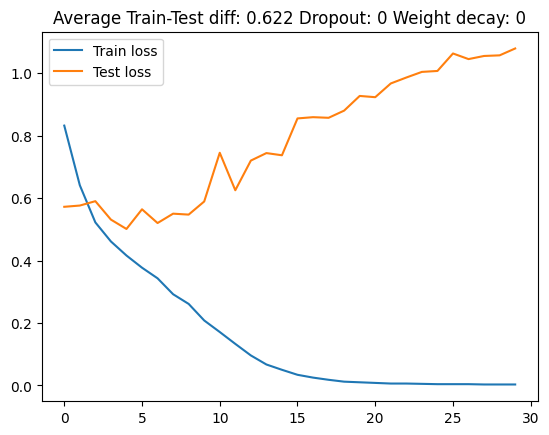

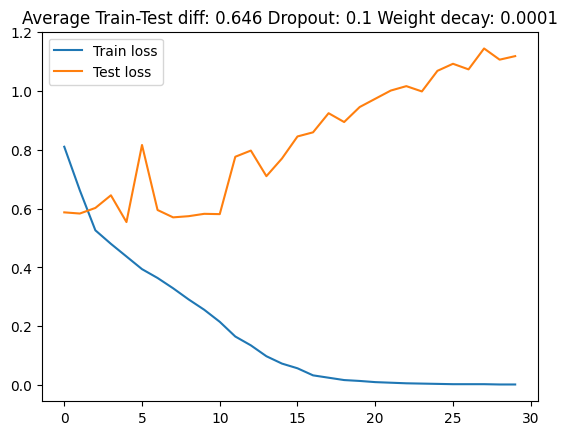

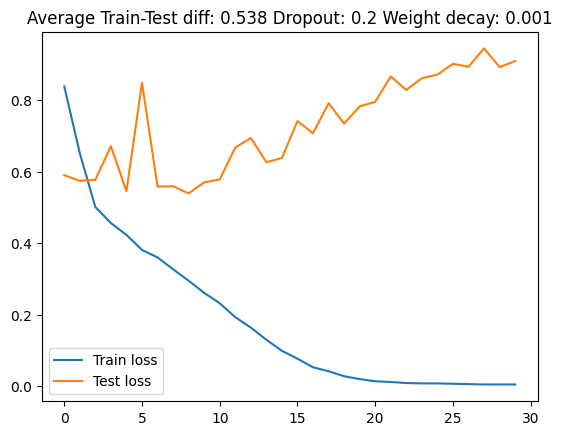

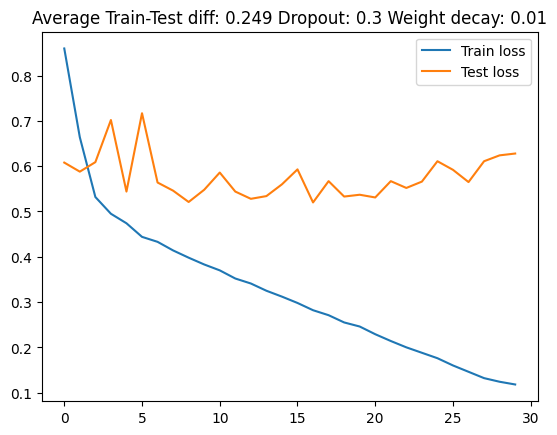

In [ ]:
avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[0]) - np.mean(val_losses_ls_final[0]), 3))
plt.plot(train_losses_ls_final[0], label='Train loss')
plt.plot(val_losses_ls_final[0], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0} Weight decay: {0}')
plt.show()

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[1]) - np.mean(val_losses_ls_final[1]), 3))
plt.plot(train_losses_ls_final[1], label='Train loss')
plt.plot(val_losses_ls_final[1], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.1} Weight decay: {0.0001}')
plt.show()

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[2]) - np.mean(val_losses_ls_final[2]), 3))
plt.plot(train_losses_ls_final[2], label='Train loss')
plt.plot(val_losses_ls_final[2], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.2} Weight decay: {0.001}')
plt.show()

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[3]) - np.mean(val_losses_ls_final[3]), 3))
plt.plot(train_losses_ls_final[3], label='Train loss')
plt.plot(val_losses_ls_final[3], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.3} Weight decay: {0.01}')
plt.show()

## Test's μόνο με dropout

In [ ]:
dropout_values = [0.0, 0.1, 0.2, 0.3, 0.4]

epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()
train_losses_ls = []
val_losses_ls = []
train_losses_ls_final = []
val_losses_ls_final = []

for dropout in dropout_values:
  model = CNN_5(activation_fn, dropout)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
  set_seed()
  #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
  model, _, _, train_losses_ls, val_losses_ls, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  train_losses_ls_final.append([round(val.item(), 3) for val in train_losses_ls])
  val_losses_ls_final.append([round(val.item(), 3) for val in val_losses_ls])
  #val_losses_ls, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)

Epoch 1
loss: 1.383777  [    0/ 3200]
loss: 0.522970  [ 1024/ 3200]
loss: 0.327828  [ 2048/ 3200]
loss: 0.345212  [ 3072/ 3200]
f1_val = 0.7495463869927234
Epoch 2
loss: 0.518763  [    0/ 3200]
loss: 0.503756  [ 1024/ 3200]
loss: 0.383641  [ 2048/ 3200]
loss: 0.974152  [ 3072/ 3200]
f1_val = 0.7925278681249475
Epoch 3
loss: 0.418190  [    0/ 3200]
loss: 0.583647  [ 1024/ 3200]
loss: 0.467368  [ 2048/ 3200]
loss: 0.468468  [ 3072/ 3200]
f1_val = 0.7507853131332882
Epoch 4
loss: 0.359775  [    0/ 3200]
loss: 0.321232  [ 1024/ 3200]
loss: 0.523164  [ 2048/ 3200]
loss: 0.408658  [ 3072/ 3200]
f1_val = 0.7972982478235022
Epoch 5
loss: 0.215170  [    0/ 3200]
loss: 0.399729  [ 1024/ 3200]
loss: 0.368367  [ 2048/ 3200]
loss: 0.332656  [ 3072/ 3200]
f1_val = 0.7975846321439666
Epoch 6
loss: 1.062236  [    0/ 3200]
loss: 0.343153  [ 1024/ 3200]
loss: 0.485028  [ 2048/ 3200]
loss: 0.189092  [ 3072/ 3200]
f1_val = 0.790004187760961
Epoch 7
loss: 0.195996  [    0/ 3200]
loss: 0.089860  [ 1024/ 320

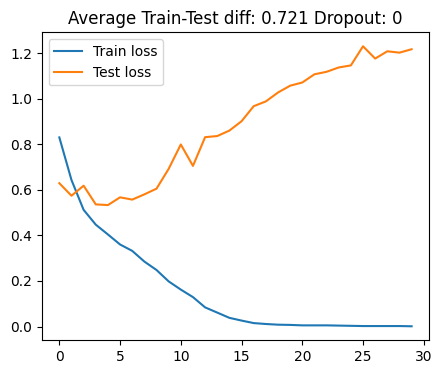

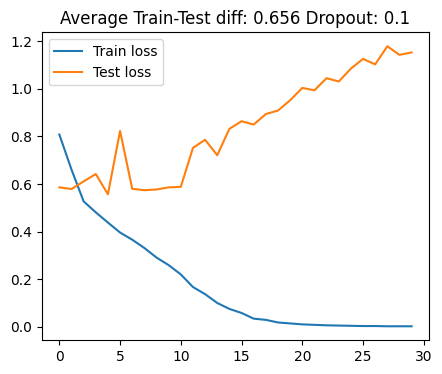

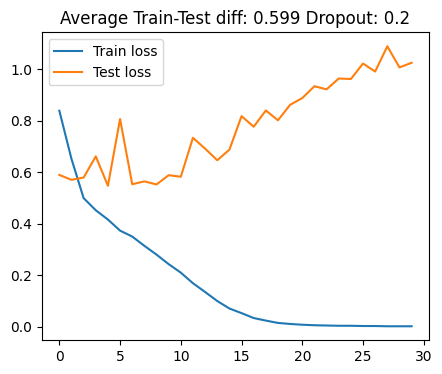

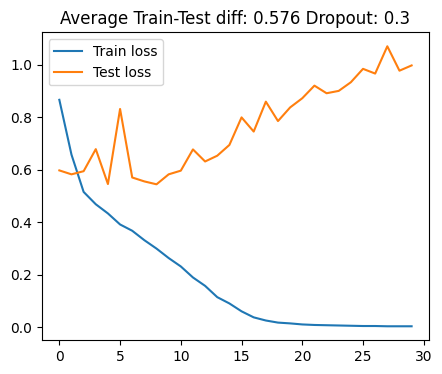

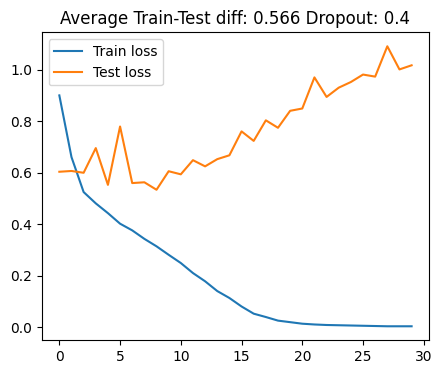

In [ ]:
avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[0]) - np.mean(val_losses_ls_final[0]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[0], label='Train loss')
plt.plot(val_losses_ls_final[0], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0}')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[1]) - np.mean(val_losses_ls_final[1]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[1], label='Train loss')
plt.plot(val_losses_ls_final[1], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.1}')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[2]) - np.mean(val_losses_ls_final[2]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[2], label='Train loss')
plt.plot(val_losses_ls_final[2], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.2}')


avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[3]) - np.mean(val_losses_ls_final[3]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[3], label='Train loss')
plt.plot(val_losses_ls_final[3], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.3}')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[4]) - np.mean(val_losses_ls_final[4]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[4], label='Train loss')
plt.plot(val_losses_ls_final[4], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.4}')


plt.show()

## Test's μόνο με Weight decay

In [ ]:
weight_decay_values = [0, 0.0001, 0.001, 0.01]

epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()
train_losses_ls = []
val_losses_ls = []
train_losses_ls_final = []
val_losses_ls_final = []

for weight in weight_decay_values:
  model = CNN_5(activation_fn, 0)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay=weight)
  lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
  set_seed()
  #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
  model, _, _, train_losses_ls, val_losses_ls, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  train_losses_ls_final.append([round(val.item(), 3) for val in train_losses_ls])
  val_losses_ls_final.append([round(val.item(), 3) for val in val_losses_ls])
  #val_losses_ls, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)

Epoch 1
loss: 1.383777  [    0/ 3200]
loss: 0.522970  [ 1024/ 3200]
loss: 0.327828  [ 2048/ 3200]
loss: 0.345212  [ 3072/ 3200]
f1_val = 0.7495463869927234
Epoch 2
loss: 0.518763  [    0/ 3200]
loss: 0.503756  [ 1024/ 3200]
loss: 0.383641  [ 2048/ 3200]
loss: 0.974152  [ 3072/ 3200]
f1_val = 0.7925278681249475
Epoch 3
loss: 0.418190  [    0/ 3200]
loss: 0.583647  [ 1024/ 3200]
loss: 0.467368  [ 2048/ 3200]
loss: 0.468468  [ 3072/ 3200]
f1_val = 0.7507853131332882
Epoch 4
loss: 0.359775  [    0/ 3200]
loss: 0.321232  [ 1024/ 3200]
loss: 0.523164  [ 2048/ 3200]
loss: 0.408658  [ 3072/ 3200]
f1_val = 0.7972982478235022
Epoch 5
loss: 0.215170  [    0/ 3200]
loss: 0.399729  [ 1024/ 3200]
loss: 0.368367  [ 2048/ 3200]
loss: 0.332656  [ 3072/ 3200]
f1_val = 0.7975846321439666
Epoch 6
loss: 1.062236  [    0/ 3200]
loss: 0.343153  [ 1024/ 3200]
loss: 0.485028  [ 2048/ 3200]
loss: 0.189092  [ 3072/ 3200]
f1_val = 0.790004187760961
Epoch 7
loss: 0.195996  [    0/ 3200]
loss: 0.089860  [ 1024/ 320

Text(0.5, 1.0, 'Average Train-Test diff: 0.234 Weight-Decay: 0.01')

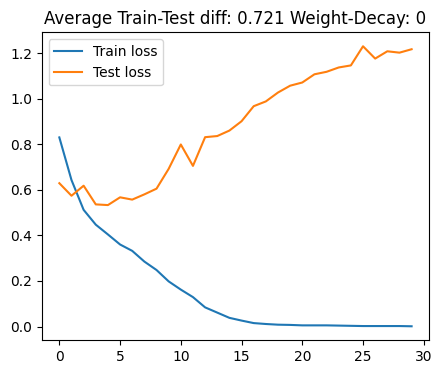

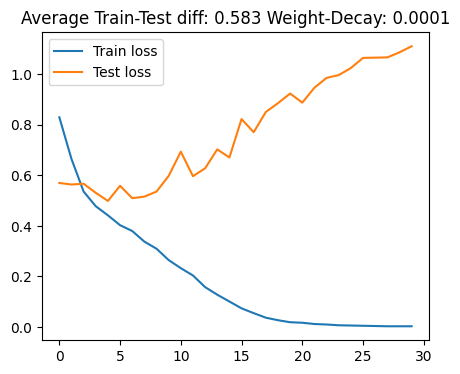

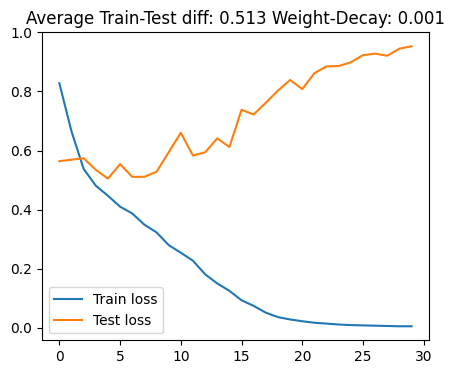

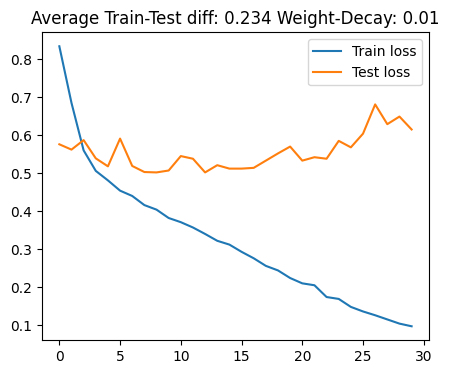

In [ ]:
avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[0]) - np.mean(val_losses_ls_final[0]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[0], label='Train loss')
plt.plot(val_losses_ls_final[0], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0}')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[1]) - np.mean(val_losses_ls_final[1]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[1], label='Train loss')
plt.plot(val_losses_ls_final[1], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0.0001}')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[2]) - np.mean(val_losses_ls_final[2]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[2], label='Train loss')
plt.plot(val_losses_ls_final[2], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0.001}')


avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[3]) - np.mean(val_losses_ls_final[3]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[3], label='Train loss')
plt.plot(val_losses_ls_final[3], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0.01}')



## Test's με 60 epochs
### Dropout και Weight decay

In [ ]:
weight_decay_values = [0.0001, 0.001, 0.01]
dropout_values = [0.1, 0.2, 0.3]

epochs= 60
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()
train_losses_ls = []
val_losses_ls = []
train_losses_ls_final = []
val_losses_ls_final = []

for weight, dropout in zip(weight_decay_values, dropout_values):
  model = CNN_5(activation_fn, dropout)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay=weight)
  lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
  set_seed()
  #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
  model, _, _, train_losses_ls, val_losses_ls, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  train_losses_ls_final.append([round(val.item(), 3) for val in train_losses_ls])
  val_losses_ls_final.append([round(val.item(), 3) for val in val_losses_ls])
  #val_losses_ls, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)

Epoch 1
loss: 1.380689  [    0/ 3200]
loss: 0.503962  [ 1024/ 3200]
loss: 0.253244  [ 2048/ 3200]
loss: 0.385877  [ 3072/ 3200]
f1_val = 0.763411963954426
Epoch 2
loss: 0.625987  [    0/ 3200]
loss: 0.470256  [ 1024/ 3200]
loss: 0.243923  [ 2048/ 3200]
loss: 0.595634  [ 3072/ 3200]
f1_val = 0.7798598851978931
Epoch 3
loss: 0.559664  [    0/ 3200]
loss: 0.773253  [ 1024/ 3200]
loss: 0.425945  [ 2048/ 3200]
loss: 0.458984  [ 3072/ 3200]
f1_val = 0.7680539972295147
Epoch 4
loss: 0.570899  [    0/ 3200]
loss: 0.107806  [ 1024/ 3200]
loss: 0.181911  [ 2048/ 3200]
loss: 0.594753  [ 3072/ 3200]
f1_val = 0.7185527357949631
Epoch 5
loss: 0.776557  [    0/ 3200]
loss: 0.335167  [ 1024/ 3200]
loss: 0.471021  [ 2048/ 3200]
loss: 0.386768  [ 3072/ 3200]
f1_val = 0.7829871268159398
Epoch 6
loss: 0.443763  [    0/ 3200]
loss: 0.179432  [ 1024/ 3200]
loss: 0.383664  [ 2048/ 3200]
loss: 0.402191  [ 3072/ 3200]
f1_val = 0.7318089462030329
Epoch 7
loss: 0.552755  [    0/ 3200]
loss: 0.254756  [ 1024/ 320

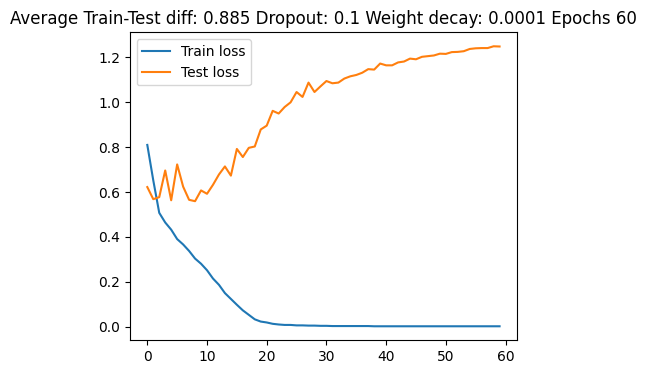

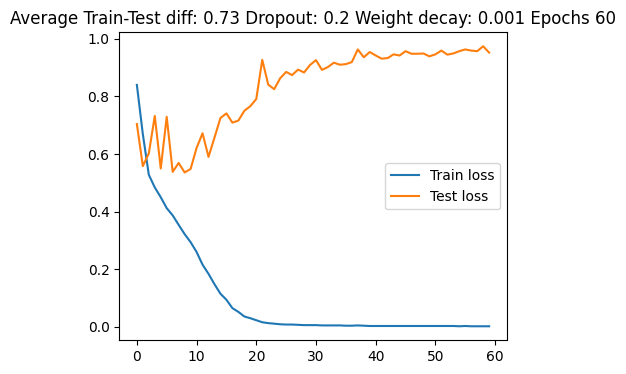

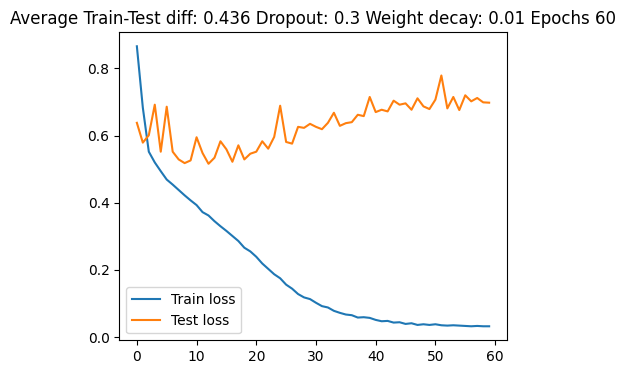

In [ ]:
avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[0]) - np.mean(val_losses_ls_final[0]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[0], label='Train loss')
plt.plot(val_losses_ls_final[0], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.1} Weight decay: {0.0001} Epochs 60')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[1]) - np.mean(val_losses_ls_final[1]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[1], label='Train loss')
plt.plot(val_losses_ls_final[1], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.2} Weight decay: {0.001} Epochs 60')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[2]) - np.mean(val_losses_ls_final[2]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[2], label='Train loss')
plt.plot(val_losses_ls_final[2], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.3} Weight decay: {0.01} Epochs 60')

plt.show()

### Test's μόνο με Dropout

In [ ]:
dropout_values = [0.1, 0.2, 0.3]

epochs= 60
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()
train_losses_ls = []
val_losses_ls = []
train_losses_ls_final = []
val_losses_ls_final = []

for dropout in dropout_values:
  model = CNN_5(activation_fn, dropout)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
  set_seed()
  #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
  model, _, _, train_losses_ls, val_losses_ls, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  train_losses_ls_final.append([round(val.item(), 3) for val in train_losses_ls])
  val_losses_ls_final.append([round(val.item(), 3) for val in val_losses_ls])
  #val_losses_ls, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)

Epoch 1
loss: 1.378908  [    0/ 3200]
loss: 0.540633  [ 1024/ 3200]
loss: 0.274701  [ 2048/ 3200]
loss: 0.298742  [ 3072/ 3200]
f1_val = 0.7701499651686234
Epoch 2
loss: 0.594600  [    0/ 3200]
loss: 0.406622  [ 1024/ 3200]
loss: 0.262573  [ 2048/ 3200]
loss: 0.662571  [ 3072/ 3200]
f1_val = 0.7654503656708878
Epoch 3
loss: 0.575889  [    0/ 3200]
loss: 0.820256  [ 1024/ 3200]
loss: 0.393809  [ 2048/ 3200]
loss: 0.530194  [ 3072/ 3200]
f1_val = 0.7635299451734275
Epoch 4
loss: 0.527135  [    0/ 3200]
loss: 0.099826  [ 1024/ 3200]
loss: 0.227732  [ 2048/ 3200]
loss: 0.568536  [ 3072/ 3200]
f1_val = 0.7207824145955899
Epoch 5
loss: 0.859998  [    0/ 3200]
loss: 0.269776  [ 1024/ 3200]
loss: 0.564489  [ 2048/ 3200]
loss: 0.371451  [ 3072/ 3200]
f1_val = 0.7822602466091503
Epoch 6
loss: 0.486300  [    0/ 3200]
loss: 0.209603  [ 1024/ 3200]
loss: 0.480985  [ 2048/ 3200]
loss: 0.387450  [ 3072/ 3200]
f1_val = 0.7314989382675785
Epoch 7
loss: 0.488911  [    0/ 3200]
loss: 0.217698  [ 1024/ 32

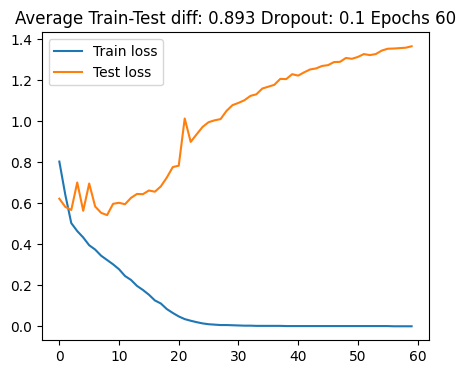

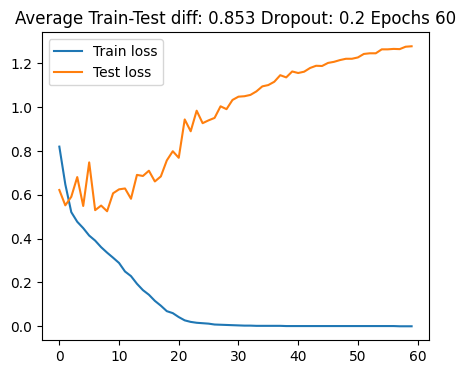

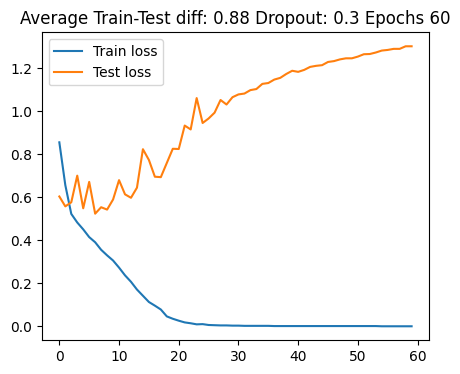

In [ ]:
avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[0]) - np.mean(val_losses_ls_final[0]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[0], label='Train loss')
plt.plot(val_losses_ls_final[0], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.1} Epochs 60')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[1]) - np.mean(val_losses_ls_final[1]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[1], label='Train loss')
plt.plot(val_losses_ls_final[1], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.2} Epochs 60')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[2]) - np.mean(val_losses_ls_final[2]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[2], label='Train loss')
plt.plot(val_losses_ls_final[2], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Dropout: {0.3} Epochs 60')

plt.show()

### Test's μόνο με Weight Decay

In [ ]:
weight_decay_values = [0.0001, 0.001, 0.01]

epochs= 60
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()
train_losses_ls = []
val_losses_ls = []
train_losses_ls_final = []
val_losses_ls_final = []

for weight in weight_decay_values:
  model = CNN_5(activation_fn, 0)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay=weight)
  lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
  set_seed()
  #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
  model, _, _, train_losses_ls, val_losses_ls, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)
  train_losses_ls_final.append([round(val.item(), 3) for val in train_losses_ls])
  val_losses_ls_final.append([round(val.item(), 3) for val in val_losses_ls])
  #val_losses_ls, f1_macro, accuracy, _ = evaluate(val_dataloader_mel, model, loss_fn, device)

Epoch 1
loss: 1.404521  [    0/ 3200]
loss: 0.583596  [ 1024/ 3200]
loss: 0.380729  [ 2048/ 3200]
loss: 0.309881  [ 3072/ 3200]
f1_val = 0.7538282729756433
Epoch 2
loss: 0.791328  [    0/ 3200]
loss: 0.356346  [ 1024/ 3200]
loss: 0.311878  [ 2048/ 3200]
loss: 1.014412  [ 3072/ 3200]
f1_val = 0.8017394683963854
Epoch 3
loss: 0.403207  [    0/ 3200]
loss: 0.542912  [ 1024/ 3200]
loss: 0.499737  [ 2048/ 3200]
loss: 0.432620  [ 3072/ 3200]
f1_val = 0.7607305774739183
Epoch 4
loss: 0.337478  [    0/ 3200]
loss: 0.471512  [ 1024/ 3200]
loss: 0.703246  [ 2048/ 3200]
loss: 0.423582  [ 3072/ 3200]
f1_val = 0.7977027141011185
Epoch 5
loss: 0.280734  [    0/ 3200]
loss: 0.444525  [ 1024/ 3200]
loss: 0.392266  [ 2048/ 3200]
loss: 0.311734  [ 3072/ 3200]
f1_val = 0.8132594524127091
Epoch 6
loss: 1.200668  [    0/ 3200]
loss: 0.439434  [ 1024/ 3200]
loss: 0.535089  [ 2048/ 3200]
loss: 0.298777  [ 3072/ 3200]
f1_val = 0.8068042846330472
Epoch 7
loss: 0.244114  [    0/ 3200]
loss: 0.105313  [ 1024/ 32

Text(0.5, 1.0, 'Average Train-Test diff: 0.427 Weight-Decay: 0.01')

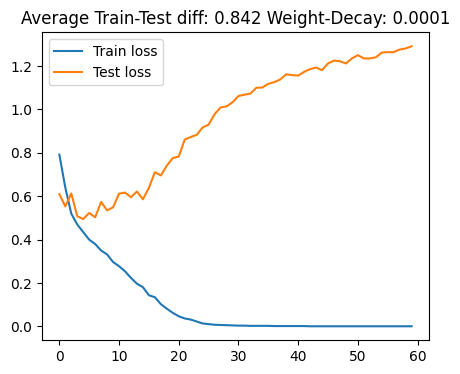

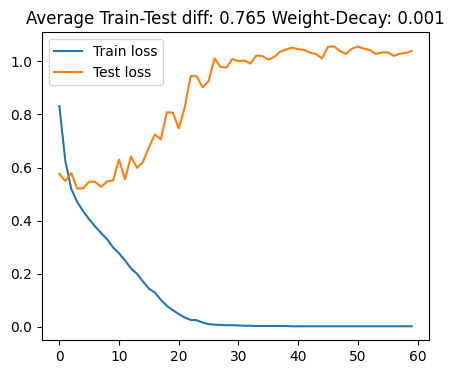

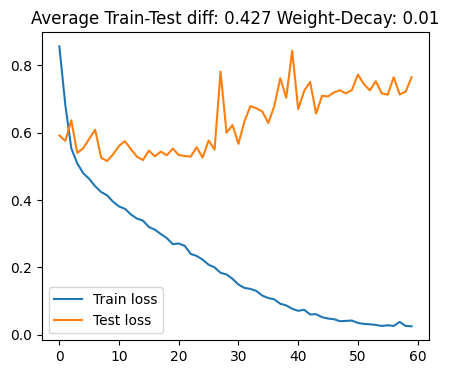

In [ ]:
avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[0]) - np.mean(val_losses_ls_final[0]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[0], label='Train loss')
plt.plot(val_losses_ls_final[0], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0.0001}')

avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[1]) - np.mean(val_losses_ls_final[1]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[1], label='Train loss')
plt.plot(val_losses_ls_final[1], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0.001}')


avg_diff = np.abs(np.round(np.mean(train_losses_ls_final[2]) - np.mean(val_losses_ls_final[2]), 3))
plt.figure(figsize=(5,4))
plt.plot(train_losses_ls_final[2], label='Train loss')
plt.plot(val_losses_ls_final[2], label='Test loss')
plt.legend()
plt.title(f'Average Train-Test diff: {avg_diff} Weight-Decay: {0.01}')

### Βήμα 7: Training efficiency
### Batch Size

In [ ]:
results ={'Batch size':[], 'Accuracy':[], 'F1 score': [], 'Time': []}
epochs = 30

for i in range(7):
    batch_size = 2**(i+1)
    print(f'BATCH SIZE: {batch_size}\n')
    set_seed()
    train_dataloader_mel_batch = DataLoader(train_dataset_mel, batch_size=batch_size, shuffle=True)
    val_dataloader_mel_batch = DataLoader(val_dataset_mel, batch_size=batch_size, shuffle=True)
    test_dataloader_mel_batch = DataLoader(test_dataset_mel, batch_size=batch_size, shuffle=False)

    model = CNN_5(activation_fn, 0.1)
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
    start_time = time.time()
    #model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
    model, _, f1, train_losses_ls, val_losses_ls, accuracy = choose_best_model(epochs, learning_rate, train_dataloader_mel_batch, val_dataloader_mel_batch, model, optimizer)
    end_time = time.time()
    results['Batch size'].append(batch_size)
    results['Accuracy'].append(accuracy)
    results['F1 score'].append(f1)
    results['Time'].append(end_time - start_time)

BATCH SIZE: 2

Epoch 1
loss: 1.401448  [    0/ 3200]
loss: 1.117258  [  128/ 3200]
loss: 0.497029  [  256/ 3200]
loss: 0.905334  [  384/ 3200]
loss: 2.021739  [  512/ 3200]
loss: 0.948709  [  640/ 3200]
loss: 1.067721  [  768/ 3200]
loss: 1.024471  [  896/ 3200]
loss: 1.389359  [ 1024/ 3200]
loss: 1.098041  [ 1152/ 3200]
loss: 0.608550  [ 1280/ 3200]
loss: 0.461934  [ 1408/ 3200]
loss: 1.346127  [ 1536/ 3200]
loss: 0.808769  [ 1664/ 3200]
loss: 1.172785  [ 1792/ 3200]
loss: 0.742853  [ 1920/ 3200]
loss: 0.517269  [ 2048/ 3200]
loss: 0.125954  [ 2176/ 3200]
loss: 0.615912  [ 2304/ 3200]
loss: 0.666080  [ 2432/ 3200]
loss: 0.939448  [ 2560/ 3200]
loss: 0.355736  [ 2688/ 3200]
loss: 0.344109  [ 2816/ 3200]
loss: 0.330853  [ 2944/ 3200]
loss: 1.510721  [ 3072/ 3200]
f1_val = 0.7544919559313839
Epoch 2
loss: 0.042038  [    0/ 3200]
loss: 1.443992  [  128/ 3200]
loss: 0.251144  [  256/ 3200]
loss: 0.061843  [  384/ 3200]
loss: 0.294326  [  512/ 3200]
loss: 0.294320  [  640/ 3200]
loss: 0.198

### Παρατηρούμε πως την καλύτερη απόδοση ως προς το F1 score την πετυχαίνει το μοντέλο όπου χρησιμοποιήθηκε batch size ίσο με 32

In [ ]:
results['Time'] = np.round(results['Time'], 2)/60 # Στρογγυλοποίηση στα 2 ψηφία και μετατροπή σε λεπτά
df = pd.DataFrame.from_dict(results)
print(df)

   Batch size  Accuracy  F1 score       Time
0           2  0.777917  0.798609  20.088500
1           4  0.788292  0.807966  12.662833
2           8  0.782417  0.805884  16.186667
3          16  0.785542  0.805406  15.609833
4          32  0.781500  0.807270   9.065667
5          64  0.781708  0.804190   8.696500
6         128  0.771958  0.807748   6.306333


### Early stopping

In [ ]:
def train_early_stoping(optimizer, dataloader, loss_fn, model, device, epochs, patience):
    set_seed()
    stop_epoch = epochs
    init_patience = patience
    f1_val_ls = []
    start_time = time.time()
    for i in range(epochs):
        train_loss, model = train_one_epoch(optimizer, dataloader, loss_fn, model, device)
        val_loss, f1_val, _, _ = evaluate(dataloader, model, loss_fn, device)
        f1_val_ls.append(f1_val)
        val_loss = np.round(val_loss, 4)
        print(f'val_loss = {val_loss}\n')
        if i == 0:
            best_loss = val_loss
        elif val_loss >= best_loss:
            patience -= 1
        else:
            patience = init_patience
            best_loss = val_loss

        if patience == 0:
            stop_epoch = i+1
            break
    end_time = time.time()
    duration = end_time - start_time

    return model, np.mean(f1_val_ls), stop_epoch, duration



In [ ]:
set_seed()

train_dataloader_mel_early = DataLoader(train_dataset_mel, batch_size=32, shuffle=True)
val_dataloader_mel_early = DataLoader(val_dataset_mel, batch_size=32, shuffle=True)
test_dataloader_mel_early = DataLoader(test_dataset_mel, batch_size=32, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
device = 'cpu'
epochs = 30
learning_rate = 2e-3
activation_fn = nn.ELU()
model = CNN_5(activation_fn, 0.1)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)

results = {'F1-Val':[], 'Stop Epoch':[], 'Duration':[], 'Patience':[]}
for pat in range(2,10,2):
    model, f1_val, stop_epoch, duration = train_early_stoping(optimizer, train_dataloader_mel, loss_fn, model, device, epochs, pat)
    results['F1-Val'].append(f1_val)
    results['Stop Epoch'].append(stop_epoch)
    results['Duration'].append(duration)
    results['Patience'].append(pat)


loss: 1.378908  [    0/ 3200]
loss: 0.540633  [ 1024/ 3200]
loss: 0.274701  [ 2048/ 3200]
loss: 0.298742  [ 3072/ 3200]
val_loss = 0.5729

loss: 0.594600  [    0/ 3200]
loss: 0.406622  [ 1024/ 3200]
loss: 0.262573  [ 2048/ 3200]
loss: 0.662571  [ 3072/ 3200]
val_loss = 0.4993

loss: 0.575889  [    0/ 3200]
loss: 0.820256  [ 1024/ 3200]
loss: 0.393809  [ 2048/ 3200]
loss: 0.530194  [ 3072/ 3200]
val_loss = 0.4521

loss: 0.527135  [    0/ 3200]
loss: 0.099826  [ 1024/ 3200]
loss: 0.227732  [ 2048/ 3200]
loss: 0.568536  [ 3072/ 3200]
val_loss = 0.5729

loss: 0.859998  [    0/ 3200]
loss: 0.269776  [ 1024/ 3200]
loss: 0.564489  [ 2048/ 3200]
loss: 0.371451  [ 3072/ 3200]
val_loss = 0.407

loss: 0.486300  [    0/ 3200]
loss: 0.209603  [ 1024/ 3200]
loss: 0.480985  [ 2048/ 3200]
loss: 0.387450  [ 3072/ 3200]
val_loss = 0.5196

loss: 0.488911  [    0/ 3200]
loss: 0.217698  [ 1024/ 3200]
loss: 0.461156  [ 2048/ 3200]
loss: 0.334016  [ 3072/ 3200]
val_loss = 0.3983

loss: 0.144200  [    0/ 3200

In [ ]:
df = pd.DataFrame.from_dict(results)
print(df)

     F1-Val  Stop Epoch    Duration
0  0.993746          23  595.461348
1  1.000000          30  389.848359
2  1.000000          12  136.963123
3  1.000000           9  101.530485


## Ερώτημα 4: Testing

In [14]:
import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21


def download_youtube(url):
    command = f'yt-dlp --extract-audio --audio-format wav --output temp.wav --postprocessor-args "-ar 8000" ' + url + " --quiet"
    os.system(command)


def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save("youtube_melgrams.npy", melgrams)


In [17]:
weight_decay = 0.01

epochs= 30
learning_rate = 2e-3
dataloader= train_dataloader_mel
device = 'cpu'
activation_fn = nn.ELU()
loss_fn = nn.CrossEntropyLoss()

model = CNN_5(activation_fn, 0)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
lr.CosineAnnealingWarmRestarts(optimizer, T_0=4)
set_seed()
#model, losses_ls = train(epochs, optimizer, dataloader, loss_fn, model, device)
model, _, _, _, _, _ = choose_best_model(epochs, learning_rate, dataloader, val_dataloader_mel, model, optimizer)


Epoch 1
loss: 1.380301  [    0/ 3200]
loss: 0.492403  [ 1024/ 3200]
loss: 0.254028  [ 2048/ 3200]
loss: 0.336254  [ 3072/ 3200]
f1_val = 0.7383433104512235
Epoch 2
loss: 0.638999  [    0/ 3200]
loss: 0.479549  [ 1024/ 3200]
loss: 0.486135  [ 2048/ 3200]
loss: 1.115794  [ 3072/ 3200]
f1_val = 0.7994911505158396
Epoch 3
loss: 0.416849  [    0/ 3200]
loss: 0.584714  [ 1024/ 3200]
loss: 0.475439  [ 2048/ 3200]
loss: 0.452695  [ 3072/ 3200]
f1_val = 0.7260021421265668
Epoch 4
loss: 0.483119  [    0/ 3200]
loss: 0.379076  [ 1024/ 3200]
loss: 0.561097  [ 2048/ 3200]
loss: 0.332687  [ 3072/ 3200]
f1_val = 0.7898966995460114
Epoch 5
loss: 0.314948  [    0/ 3200]
loss: 0.488827  [ 1024/ 3200]
loss: 0.433651  [ 2048/ 3200]
loss: 0.309610  [ 3072/ 3200]
f1_val = 0.8031819570666516
Epoch 6
loss: 1.146574  [    0/ 3200]
loss: 0.501807  [ 1024/ 3200]
loss: 0.507421  [ 2048/ 3200]
loss: 0.270797  [ 3072/ 3200]
f1_val = 0.7594443471234205
Epoch 7
loss: 0.313041  [    0/ 3200]
loss: 0.214306  [ 1024/ 32

### Βήμα 1: Inference


In [ ]:
def make_predictions(model, dataloader):
  pass

### Βήμα 2: Κατέβασμα μουσικής

In [18]:
%%capture
# Αντί για youtube-dl βάζουμε yt-dlp
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/yt-dlp -o /usr/local/bin/yt-dlp
!sudo chmod a+rx /usr/local/bin/yt-dlp

In [19]:
music_urls = {'classic':['https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano', 'https://www.youtube.com/watch?v=H5eVx5-pC9E&ab_channel=GnosisMundi'],
              'pop':['https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna', 'https://www.youtube.com/watch?v=C-u5WLJ9Yk4&ab_channel=BritneySpearsVEVO'],
              'rock':['https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO', 'https://www.youtube.com/watch?v=vEc9nXErU-Y&ab_channel=OmgUrFace1'],
              'blues':['https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania', 'https://www.youtube.com/watch?v=b76kjd5nvMg&ab_channel=Tomi_C']}

### Δημιουργούμε τα .npy files για κάθε είδος μουσικής



In [20]:
for url in music_urls['classic']:
  youtube_to_melgram(url)

FileNotFoundError: ignored